In [123]:

######## Question 1 ########

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import curve_fit
from lmfit import minimize, Parameters, report_fit

df = pd.read_csv('./DonnesCroissanceTumorale.csv',sep=';', header=None)
df = pd.DataFrame(df.T)
new_header = df.iloc[0] 
df = df[1:]
df.columns = new_header
df = df.rename(columns={'contrôle (moyenne)': 'controleM', 'contrôle (écart-type)': 'controleS', 'traitement (moyenne)': 'traitementM', 'traitement (écart-type) ': 'traitementS'})
df = df.apply(pd.to_numeric)
print(df)

0   temps    controleM    controleS  traitementM  traitementS
1     1.0   113.759819    22.859078   118.694790     8.032671
2     3.0   224.732254    48.179178   201.301467     4.195288
3     5.0   437.007275   118.952172   287.508355    17.756614
4     7.0   533.324959    95.870055   437.704611    39.149797
5     9.0   900.194983   195.695572   511.961084    36.105835
6    11.0  1460.346622   287.173734   982.886260    33.545427
7    13.0  2276.348574   358.665593  1115.376106    64.886712
8    15.0  3288.902468   720.832997  1235.958728   160.711806
9    17.0  3888.701883   670.423696  1622.577177   229.636241
10   19.0  5102.454529  1074.049494  1776.951846   247.201307


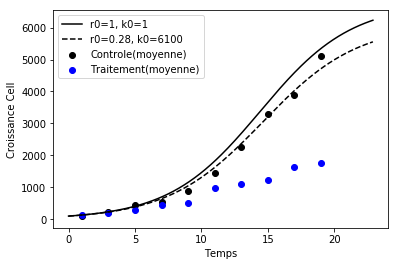

In [142]:
## modelisation sans traitement

def croissanceCell(s, t, r, k):
    return (r*s*(1-(s/k)))

def solve(tmp, r0, k0):
    return (odeint(croissanceCell, [100], tmp, args=(r0, k0)).ravel())

def residual(parm, tmp, CM):
    return (solve(tmp, parm['r'].value, parm['k'].value) - CM)

params = Parameters()
params.add('r', value=1.0, min= 0.0, max= 1.0)
params.add('k', value=1000.0)
res = minimize(residual, params, args=(df['temps'], df['controleM']))
T = np.arange(0, 23, 0.1)
tmp = solve(T, res.params['r'].value, res.params['k'].value)
tmp2 = solve(T, 0.28, 6100)

plt.scatter(df['temps'],df['controleM'],color='k',label='Controle(moyenne)')
plt.scatter(df['temps'],df['traitementM'],color='b',label='Traitement(moyenne)')
plt.plot(T, tmp, color='k', ls='-', label='r0=1, k0=1')
plt.plot(T, tmp2, color='k', ls='--', label='r0=0.28, k0=6100')
plt.xlabel('Temps')
plt.ylabel("Croissance Cell")
plt.legend()
plt.show()
res

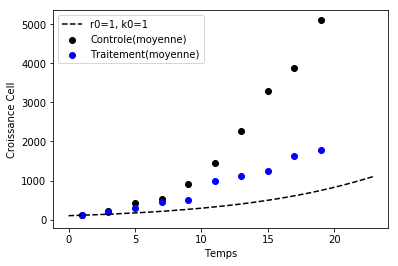

In [143]:
## modelisation avec traitement

def croissanceCellTraitement(s, t, r, k, ka, a, d):
    S, T = s
    dS = r*S*(1-(S/k)-ka*S*T)
    dT = a*S-d*T
    return [dS, dT]

def solve(tmp, r0, k0, ka0, a0, d0):
    sol = odeint(croissanceCellTraitement, [100,0], tmp, args=(r0, k0, ka0, a0, d0))
    sol1 = np.array([i[0] for i in sol])
    sol2 = np.array([i[1] for i in sol])
    return [sol1, sol2]

def residual(parm, tmp, CM):
    sol = solve(tmp, parm['r'].value, parm['k'].value, parm['ka'].value, parm['a'].value, parm['d'].value)
    return (sol[0]-CM)

params = Parameters()
params.add('r', value=1.0, min= 0.0, max= 1.0)
params.add('k', value=1000.0)
params.add('ka', value=0.0001)
params.add('a', value=1.0)
params.add('d', value=1.0)
res = minimize(residual, params, args=(df['temps'], df['controleM']))
T = np.arange(0, 23, 0.1)
tmp = solve(T, res.params['r'].value, res.params['k'].value, res.params['ka'].value, res.params['a'].value, res.params['d'].value)
plt.scatter(df['temps'],df['controleM'],color='k',label='Controle(moyenne)')
plt.scatter(df['temps'],df['traitementM'],color='b',label='Traitement(moyenne)')
plt.plot(T, tmp[0], color='k', ls='--', label='r0=1, k0=1')
plt.xlabel('Temps')
plt.ylabel("Croissance Cell")
plt.legend()
plt.show()
res

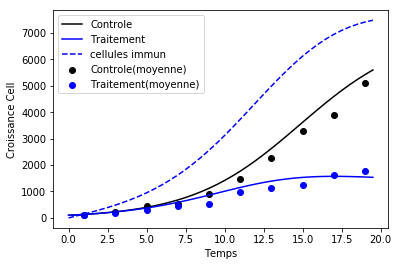

In [145]:
def croissanceCell(s, t, r, k, ka, a, d):
    Sc, S, T = s
    dSc = r*Sc*(1-(Sc/k))
    dS = (r*S*(1-(S/k))-(ka*S*T))
    dT = a*S-d*T
    return [dSc, dS, dT]

def solve(tmp, r0, k0, ka0, a0, d0):
    sol = odeint(croissanceCell, [100,100,0], tmp, args=(r0, k0, ka0, a0, d0))
    sol1 = np.array([i[0] for i in sol])
    sol2 = np.array([i[1] for i in sol])
    sol3 = np.array([i[2] for i in sol])
    return [sol1, sol2, sol3]

def residual(parm, tmp, CM):
    sol = solve(tmp, parm['r'].value, parm['k'].value, parm['ka'].value, parm['a'].value, parm['d'].value)
    sol[0]= sol[0] - CM
    sol[1]= sol[1] - CM
    return sol[0:2]

params = Parameters()
params.add('r', value=1, min= 0.0, max= 1.0)
params.add('k', value=1000)
params.add('ka', value=0.0001)
params.add('a', value=1)
params.add('d', value=1)
res = minimize(residual, params, args=(df['temps'], [df['controleM'], df['traitementM']]))
T = np.arange(0, 20, 0.5)
tmp = solve(T, result.params['r'].value, result.params['k'].value, result.params['ka'].value, result.params['a'].value, result.params['d'].value)

plt.scatter(df['temps'],df['controleM'],color='k',label='Controle(moyenne)')
plt.scatter(df['temps'],df['traitementM'],color='b',label='Traitement(moyenne)')
plt.plot(T, tmp[0], color='k', ls='-', label='Controle')
plt.plot(T, tmp[1], color='b', ls='-', label='Traitement')
plt.plot(T, tmp[2], color='b', ls='--', label='cellules immun')
plt.xlabel('Temps')
plt.ylabel("Croissance Cell")
plt.legend()
plt.show()
res

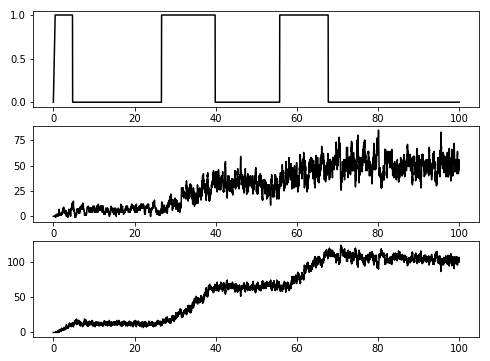

,G,P2,P2G,R,P
0.000000,10,0,0,0,0
0.444995,10,0,0,1,0
0.481413,10,0,0,1,1
0.552706,10,1,0,1,-1
0.642695,10,1,0,1,0
0.677146,9,0,1,1,1
0.737174,9,0,1,1,2
0.782980,10,1,0,1,2
0.957782,9,0,1,1,2
1.033761,9,1,1,1,1


In [154]:
######## Question 2 ########


import numpy as np
import pandas as pd
from operator import add, sub
import matplotlib.pyplot as plt
import time

#initialiser la simulation pour un nombre initial de réactifs �4⃗ = �! et � = 0
#échantillonner un chiffre aléatoire distribué uniformément entre 0 et 1
#calculer le temps d’attente τ par τ = −���(�")/�
#échantillonner un deuxième chiffre aléatoire �# uniformément distribuer entre 0 et 1 pour choisir la réaction qui aura lieu dans τ
#mettre à jour le temps, c’est-à-dire � ⟶ � + τ, et �4⃗ selon la réaction choisie et la matrice stoechiométrique �


def gillespie(var, c, T, RR, LR, dt):
    t = 0
    VAR = var
    res = [VAR]
    time = [t]
    
    while t <= T:
        tmp = np.array([VAR*i for i in LR])
        c1 = []
        for r in range(len(c)):
            if np.array_equal(np.where(tmp[r] ==0)[0], np.where(LR[r] ==0)[0]) :
                c1 += [tmp[r][np.nonzero(tmp[r])].prod()]
            else :
                c1 += [0]
        #print(c1)
        
        a = np.array(c1)*np.array(c)
        aCum = np.cumsum(a, dtype=float)
        a0 = aCum[-1]
        #print(aCum)
        #rand1 = np.random.uniform(0,1)
        #t += -np.log(rand1/a0)
        t += np.random.exponential(1/a0)
        #print(t)
        rand2=np.random.uniform(0,1)
        for r in range(len(c)):
            ar = aCum[r]
            #print(ar)
            if(ar > a0*rand2):
                VAR = np.add(np.subtract(VAR, LR[r]), RR[r])
                #print(VAR)
                break
        if t - time[-1] > dt :
            res += [VAR]
            time += [t]
    return res, time


c = np.array([1,10,0.01,10,1,1,0.1,0.01])
var = np.array([10,0,0,0,0])
tmax = 100
dt = 0.01
LR = np.array([[1,1,0,0,0], [0,0,1,0,0], [1,0,0,0,0], [0,0,0,1,0], [0,0,0,0,2], [0,1,0,0,0], [0,0,0,1,0], [0,0,0,0,1]])
RR = np.array([[0,0,1,0,0], [1,1,0,0,0], [1,0,0,1,0], [0,0,0,1,1], [0,1,0,0,0], [0,0,0,0,2], [0,0,0,0,0], [0,0,0,0,0]])


res, time = gillespie(var, c, tmax, RR, LR, dt)
df = pd.DataFrame(res, index=time, columns = ['G', 'P2', 'P2G', 'R', 'P'])

fig, ax = plt.subplots(3,1, figsize=(8,6))
ax[0].plot(df.index.values, df.R, color='k')
ax[1].plot(df.index.values, df.P, color='k')
ax[2].plot(df.index.values, df.P2, color='k')
plt.show()
display(df)

